Training Q-learning model...


/var/folders/x_/qkd8hs9148b8542nqxc89qpc0000gn/T/ipykernel_47739/1240084698.py:197: RuntimeWarning: overflow encountered in multiply
  net_worth = self.balance + self.shares_held * current_price
/var/folders/x_/qkd8hs9148b8542nqxc89qpc0000gn/T/ipykernel_47739/1240084698.py:176: RuntimeWarning: overflow encountered in multiply
  transaction_fee = self.shares_held * current_price * (self.transaction_fee_percent / 100)
/var/folders/x_/qkd8hs9148b8542nqxc89qpc0000gn/T/ipykernel_47739/1240084698.py:179: RuntimeWarning: overflow encountered in multiply
  profit_loss = (current_price - self.avg_buy_price) * self.shares_held
/var/folders/x_/qkd8hs9148b8542nqxc89qpc0000gn/T/ipykernel_47739/1240084698.py:182: RuntimeWarning: overflow encountered in multiply
  self.balance += (self.shares_held * current_price - transaction_fee)


Episode: 100, Avg Reward: nan, Avg Portfolio Value: nan, Exploration Rate: 0.61
Episode: 200, Avg Reward: 4372295545358866930543336151809495809678210536407146460867566699422941184.00, Avg Portfolio Value: 78125038325259247330928707410442123419596432711798285319776440416241610391552.00, Exploration Rate: 0.37
Episode: 300, Avg Reward: 197499165172865762278226459290711353619577588539319476289536.00, Avg Portfolio Value: 1974991652730957099130249814065722800496898387513348800280264704.00, Exploration Rate: 0.22
Episode: 400, Avg Reward: 594480577051334964407604676703289344.00, Avg Portfolio Value: 10948754176258500042267838045467575320576.00, Exploration Rate: 0.13
Episode: 500, Avg Reward: 724781856197186229693841408.00, Avg Portfolio Value: 7247818571728439326691626582016.00, Exploration Rate: 0.08
Episode: 600, Avg Reward: 1355392159117929873408.00, Avg Portfolio Value: 22590457940076966801571840.00, Exploration Rate: 0.05
Episode: 700, Avg Reward: 21395064635202285568.00, Avg Portfoli

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final Portfolio Value: $10000.00
Profit/Loss: 0.00%


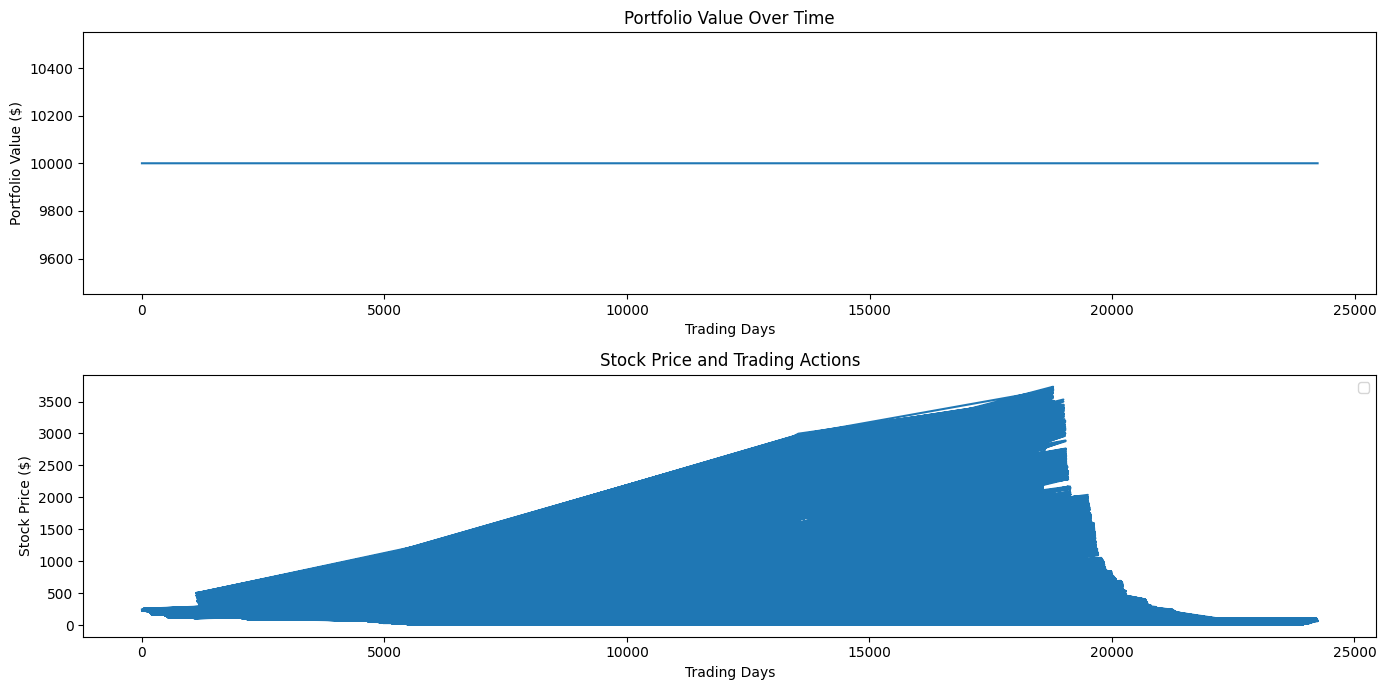

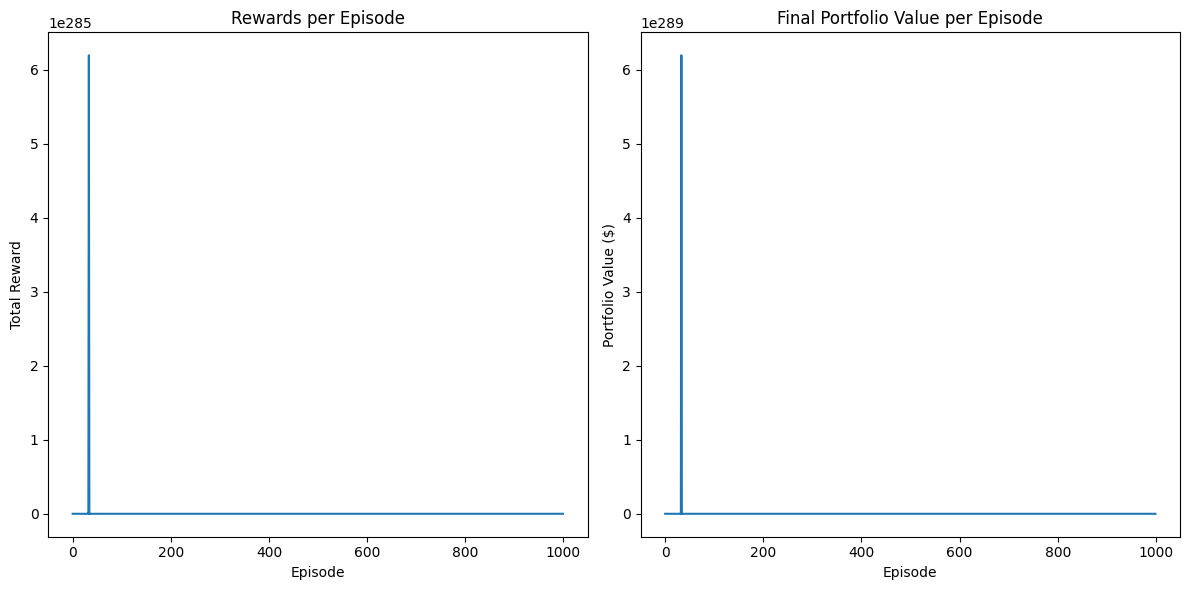

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    """
    Load stock data and preprocess it for Q-learning
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Ensure date is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    # Calculate additional features
    df['return'] = df['close'].pct_change()
    df['return_5d'] = df['close'].pct_change(periods=5)
    df['volatility'] = df['return'].rolling(window=5).std()
    
    # Drop rows with NaN values
    df = df.dropna()
    
    return df

# 2. State Representation
def get_state(data, t, n_days):
    """
    Create a state representation at time t using the past n_days
    State includes: price trends, volatility, and volume patterns
    """
    # Check if we have enough data
    if t >= len(data):
        t = len(data) - 1
    
    if t < n_days:
        # Pad with zeros if not enough history
        return np.zeros(3)
    
    # Price trend: -1 (downtrend), 0 (sideways), 1 (uptrend)
    if data['close'].iloc[t] > data['close'].iloc[t-n_days] * 1.05:
        price_trend = 1  # uptrend
    elif data['close'].iloc[t] < data['close'].iloc[t-n_days] * 0.95:
        price_trend = -1  # downtrend
    else:
        price_trend = 0  # sideways
    
    # Volatility: 0 (low), 1 (medium), 2 (high)
    recent_volatility = data['volatility'].iloc[t]
    if recent_volatility < 0.01:
        volatility_state = 0
    elif recent_volatility < 0.03:
        volatility_state = 1
    else:
        volatility_state = 2
    
    # Volume: 0 (low), 1 (normal), 2 (high)
    avg_volume = data['volume'].iloc[t-n_days:t].mean()
    current_volume = data['volume'].iloc[t]
    if current_volume > avg_volume * 1.5:
        volume_state = 2
    elif current_volume < avg_volume * 0.5:
        volume_state = 0
    else:
        volume_state = 1
    
    return np.array([price_trend, volatility_state, volume_state])

# 3. Define Actions
# 0: Hold, 1: Buy, 2: Sell
num_actions = 3

# 4. Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.995):
        # Initialize Q-table with zeros
        # 3 price trends x 3 volatility states x 3 volume states x 3 actions
        self.q_table = np.zeros((3, 3, 3, action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        
    def get_action(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() < self.exploration_rate:
            # Explore: choose random action
            return random.randrange(num_actions)
        else:
            # Exploit: choose best action from Q-table
            return np.argmax(self.q_table[int(state[0]+1), int(state[1]), int(state[2]), :])
    
    def update_q_table(self, state, action, reward, next_state):
        """Update Q-value using the Bellman equation"""
        # Clip reward to prevent explosion
        reward = np.clip(reward, -100, 100)
        
        # Current Q-value
        current_q = self.q_table[int(state[0]+1), int(state[1]), int(state[2]), action]
        
        # Maximum Q-value for next state
        max_next_q = np.max(self.q_table[int(next_state[0]+1), int(next_state[1]), int(next_state[2]), :])
        
        # Bellman equation for Q-value update
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        
        # Update Q-table
        self.q_table[int(state[0]+1), int(state[1]), int(state[2]), action] = new_q
    
    def decay_exploration(self):
        """Decay exploration rate"""
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(0.01, self.exploration_rate)  # Set minimum exploration rate

# 5. Trading Environment
class TradingEnvironment:
    def __init__(self, data, initial_balance=10000, transaction_fee_percent=0.1):
        self.data = data
        self.initial_balance = initial_balance
        self.transaction_fee_percent = transaction_fee_percent
        self.reset()
    
    def reset(self):
        """Reset the environment for a new episode"""
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.net_worth_history = [self.initial_balance]
        self.avg_buy_price = 0
        return get_state(self.data, self.current_step, n_days=5)
    
    def step(self, action):
        """Execute action and return new state, reward, and done flag"""
        # Get current price
        current_price = self.data['close'].iloc[self.current_step]
        
        # Check for NaN price
        if pd.isna(current_price):
            # Skip this step if price is NaN
            self.current_step += 1
            return get_state(self.data, self.current_step, n_days=5), 0, self.current_step >= len(self.data) - 1
        
        # Initialize reward
        reward = 0
        
        # Execute action
        if action == 1:  # Buy
            # Calculate maximum shares that can be bought
            max_shares = self.balance / current_price
            # Ensure max_shares is not NaN
            if not pd.isna(max_shares):
                shares_to_buy = int(max_shares)  # Convert to integer safely
                
                if shares_to_buy > 0:
                    # Calculate transaction fee
                    transaction_fee = shares_to_buy * current_price * (self.transaction_fee_percent / 100)
                    
                    # Update balance and shares held
                    self.balance -= (shares_to_buy * current_price + transaction_fee)
                    self.shares_held += shares_to_buy
                    
                    # Update average buy price
                    self.avg_buy_price = current_price
                    
                    # Penalize for transaction fee
                    reward -= transaction_fee / self.initial_balance  # Normalize reward
                    
        elif action == 2:  # Sell
            if self.shares_held > 0:
                # Calculate transaction fee
                transaction_fee = self.shares_held * current_price * (self.transaction_fee_percent / 100)
                
                # Calculate profit/loss
                profit_loss = (current_price - self.avg_buy_price) * self.shares_held
                
                # Update balance and shares held
                self.balance += (self.shares_held * current_price - transaction_fee)
                
                # Add profit/loss to reward (normalized)
                reward += profit_loss / self.initial_balance  # Normalize reward
                
                # Penalize for transaction fee
                reward -= transaction_fee / self.initial_balance  # Normalize reward
                
                # Reset shares held
                self.shares_held = 0
        
        # Move to next step
        self.current_step += 1
        
        # Calculate net worth
        net_worth = self.balance + self.shares_held * current_price
        self.net_worth_history.append(net_worth)
        
        # Calculate additional reward based on portfolio growth
        prev_net_worth = self.net_worth_history[-2]
        if prev_net_worth > 0:  # Prevent division by zero
            pct_change = (net_worth - prev_net_worth) / prev_net_worth
            reward += pct_change  # No additional scaling needed
        
        # Check if done
        done = self.current_step >= len(self.data) - 1
        
        # Get next state
        next_state = get_state(self.data, self.current_step, n_days=5)
        
        return next_state, reward, done

# 6. Train the model
def train_q_learning_model(data_path, num_episodes=1000):
    """
    Train a Q-learning model on stock data
    """
    # Load and preprocess data
    data = load_and_preprocess_data(data_path)
    
    # Initialize environment and agent
    env = TradingEnvironment(data)
    agent = QLearningAgent(state_size=3, action_size=num_actions)
    
    # Training statistics
    episode_rewards = []
    portfolio_values = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        
        # Episode loop
        while not done:
            # Select action
            action = agent.get_action(state)
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Update Q-table
            agent.update_q_table(state, action, reward, next_state)
            
            # Update state
            state = next_state
            
            # Accumulate reward
            total_reward += reward
        
        # Decay exploration rate
        agent.decay_exploration()
        
        # Track statistics
        episode_rewards.append(total_reward)
        
        # Check if net_worth_history has items before accessing
        if env.net_worth_history:
            portfolio_values.append(env.net_worth_history[-1])
        else:
            portfolio_values.append(env.initial_balance)
        
        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_portfolio = np.mean(portfolio_values[-100:])
            print(f"Episode: {episode+1}, Avg Reward: {avg_reward:.2f}, Avg Portfolio Value: {avg_portfolio:.2f}, Exploration Rate: {agent.exploration_rate:.2f}")
    
    return agent, episode_rewards, portfolio_values

# 7. Evaluate the trained model
def evaluate_model(agent, data_path, visualize=True):
    """
    Evaluate the trained Q-learning model on test data
    """
    # Load and preprocess test data
    test_data = load_and_preprocess_data(data_path)
    
    # Initialize environment
    env = TradingEnvironment(test_data)
    state = env.reset()
    done = False
    
    # Action history
    actions_taken = []
    
    # Evaluation loop
    while not done:
        # Select best action from Q-table (no exploration)
        action = np.argmax(agent.q_table[int(state[0]+1), int(state[1]), int(state[2]), :])
        
        # Take action
        next_state, reward, done = env.step(action)
        
        # Track action
        actions_taken.append(action)
        
        # Update state
        state = next_state
    
    # Calculate final portfolio value
    final_portfolio_value = env.net_worth_history[-1]
    profit_percent = (final_portfolio_value - env.initial_balance) / env.initial_balance * 100
    
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Profit/Loss: {profit_percent:.2f}%")
    
    # Visualize results
    if visualize:
        # Plot portfolio value over time
        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(env.net_worth_history)
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Trading Days')
        plt.ylabel('Portfolio Value ($)')
        
        # Plot stock price and actions
        plt.subplot(2, 1, 2)
        plt.plot(test_data['close'])
        
        # Mark buy actions
        buy_days = [i for i, a in enumerate(actions_taken) if a == 1]
        if buy_days:
            buy_prices = [test_data['close'].iloc[i] if i < len(test_data) else None for i in buy_days]
            buy_prices = [p for p in buy_prices if p is not None]
            buy_days = [d for d, p in zip(buy_days, [test_data['close'].iloc[i] if i < len(test_data) else None for i in buy_days]) if p is not None]
            if buy_days and buy_prices:
                plt.scatter(buy_days, buy_prices, color='green', marker='^', alpha=0.7, label='Buy')
        
        # Mark sell actions
        sell_days = [i for i, a in enumerate(actions_taken) if a == 2]
        if sell_days:
            sell_prices = [test_data['close'].iloc[i] if i < len(test_data) else None for i in sell_days]
            sell_prices = [p for p in sell_prices if p is not None]
            sell_days = [d for d, p in zip(sell_days, [test_data['close'].iloc[i] if i < len(test_data) else None for i in sell_days]) if p is not None]
            if sell_days and sell_prices:
                plt.scatter(sell_days, sell_prices, color='red', marker='v', alpha=0.7, label='Sell')
        
        plt.title('Stock Price and Trading Actions')
        plt.xlabel('Trading Days')
        plt.ylabel('Stock Price ($)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    return final_portfolio_value, profit_percent, actions_taken

# 8. Main execution
def main():
    # File path to your stock data CSV
    data_path = '../data/stock_data.csv'
    
    # Train the model
    print("Training Q-learning model...")
    agent, rewards, portfolio_values = train_q_learning_model(data_path, num_episodes=1000)
    
    # Save the trained model (Q-table)
    np.save('q_table.npy', agent.q_table)
    
    # Evaluate on test data
    print("\nEvaluating model on test data...")
    evaluate_model(agent, data_path)
    
    # Plot training progress
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(portfolio_values)
    plt.title('Final Portfolio Value per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Portfolio Value ($)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()